In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import rasterio as ro
import rioxarray as rxr
import geopandas as gpd
from skimage import morphology, filters
import matplotlib.pyplot as plt
import colorcet as cc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.lineament_extraction.utils3 import *
# from _utils3 import *
from src.lineament_extraction.potential_field_tool import *
from src.lineament_extraction.lineament_detection import *
from src.phasepack import phasesym, phasecongmono, phasecong, ppdrc, highpassmonogenic
%matplotlib inline

# 1. Load original data - tif 
data_og: loaded original input data, after replacing dummy values with NaN

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 754, 'height': 599, 'count': 1, 'crs': CRS.from_epsg(7845), 'transform': Affine(448.91956193463693, 0.0, -1465071.3975674445,
       0.0, -448.91956193463693, -3173616.964082074)}


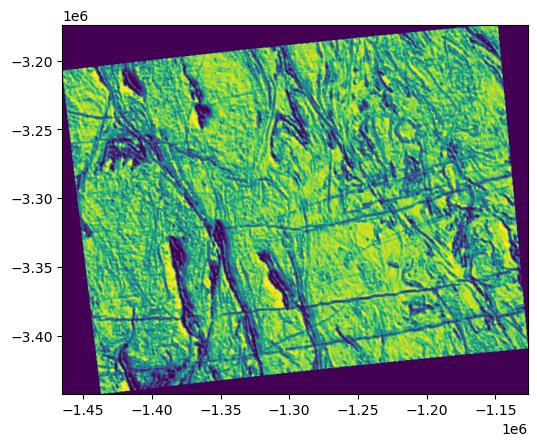

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [2]:
from rasterio.plot import show
tif_path = r"mag_rtp_test.tif"

with rasterio.open(tif_path) as src:
    print(src.meta)
    show(src)

    data = src.read()

data

--- raster band count = 1.
 ds=448.92 is an average resolution!
--- loaded! crs = EPSG:7845


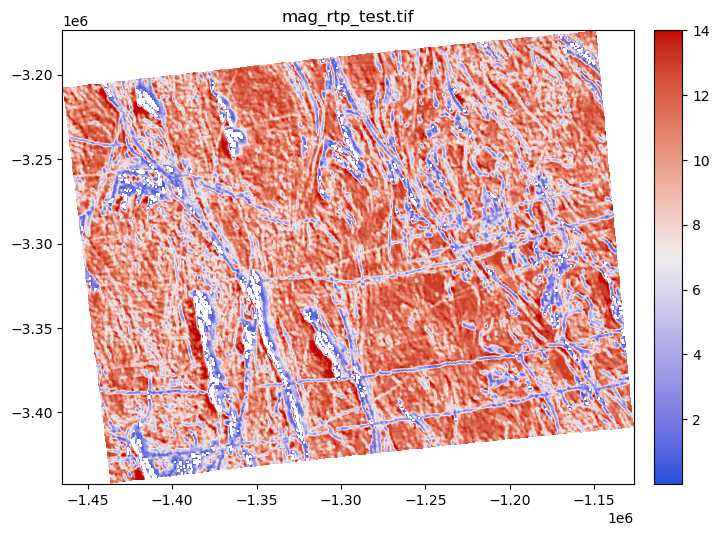

In [3]:

ds = 448.92 # interval
data_og, in_x, in_y, in_ds, in_crs, in_transform, cols, rows = read_geotif(tif_path, 1)

dummy = 0
# dummy = -999999.0
data_og[data_og==dummy]  = np.nan
nrow, ncol = data_og.shape

og_mask = data_og.copy().astype(bool)
og_mask[data_og==np.nan]  = False
og_mask[data_og!=np.nan]  = True

# display
fig, ax = plt.subplots(1, figsize=(8, 8))
x1, y1 = in_transform*(0, nrow)
x2, y2 = in_transform*(ncol, 0)
extent_og = [x1, x2, y1, y2]
ax1 = ax.imshow(data_og, extent=extent_og, cmap=cc.cm.coolwarm) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
ax.set_title(os.path.basename(tif_path))
fig.colorbar(ax1, cax=cax)

In [4]:
data_og

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

# 2. initial pre-processing - potential field transformation and filtering
- upward continuation or
- filtering

In [12]:
# upward continuation
do_upward = True
upward_height = 1000

# filtering
do_filtering = True
cutoff_ratio = 0.005
lowsig=1.5

# ~ ~  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# fill nan
if np.any(np.isnan(data_og)):
    mask = np.where(~np.isnan(data_og))
    interp = sp.interpolate.NearestNDInterpolator(np.transpose(mask), data_og[mask])
    data = interp(*np.indices(data_og.shape))
else:
    data = data_og.copy()
    
if do_upward:
    data = upcontinue(cols*ds, rows*ds, data, (nrow, ncol), upward_height).reshape((nrow, ncol))

if do_filtering:
    data1 = filters.butterworth(data, cutoff_ratio, True)
    data1 =filters.difference_of_gaussians(data1, lowsig)
else:
    data1 = data.copy()
   

In [13]:
data1

array([[ 0.02128139,  0.02204997,  0.01572657, ...,  0.01211504,
         0.01293465,  0.01347922],
       [ 0.02128831,  0.02278505,  0.0177036 , ...,  0.01698094,
         0.01785923,  0.01844824],
       [ 0.02179806,  0.0242894 ,  0.02082944, ...,  0.0230394 ,
         0.02397716,  0.02461474],
       ...,
       [-0.00478548, -0.00584284, -0.00596028, ..., -0.04048497,
        -0.07553482, -0.08398991],
       [ 0.02372575,  0.02270449,  0.02275963, ..., -0.02893061,
        -0.06800433, -0.07998651],
       [ 0.04785634,  0.04666609,  0.04647152, ..., -0.02449642,
        -0.06586198, -0.07973176]])

In [14]:
ucda = np.full(data.shape, np.nan)
ucda[mask] = data[mask]

ucda_ft = ucda.copy()
ucda_ft[mask] = data1[mask]


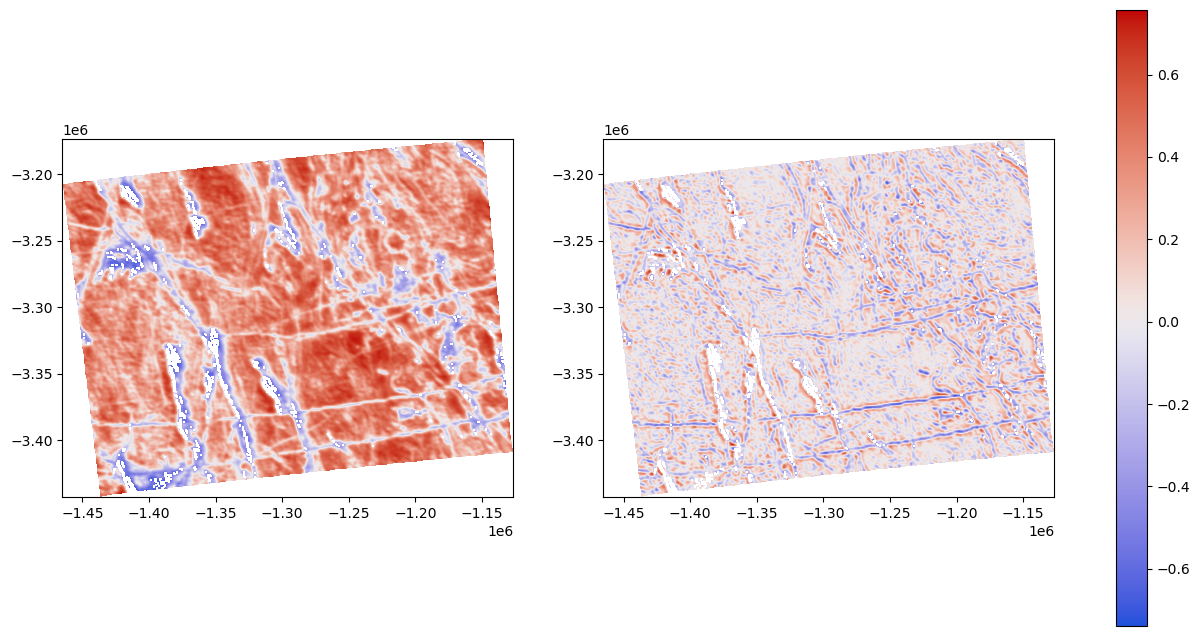

In [15]:
 
if do_upward or do_filtering:    # display
    fig, ax=plt.subplots(1,2, figsize=(16, 8))
    ax[0].imshow(ucda, extent=extent_og, cmap=cc.cm.coolwarm) 
    h1=ax[1].imshow(ucda_ft, extent=extent_og, cmap=cc.cm.coolwarm)
    plt.colorbar(h1, ax=ax)

# 3. processing: enhancement

## 3a. potential field transformation

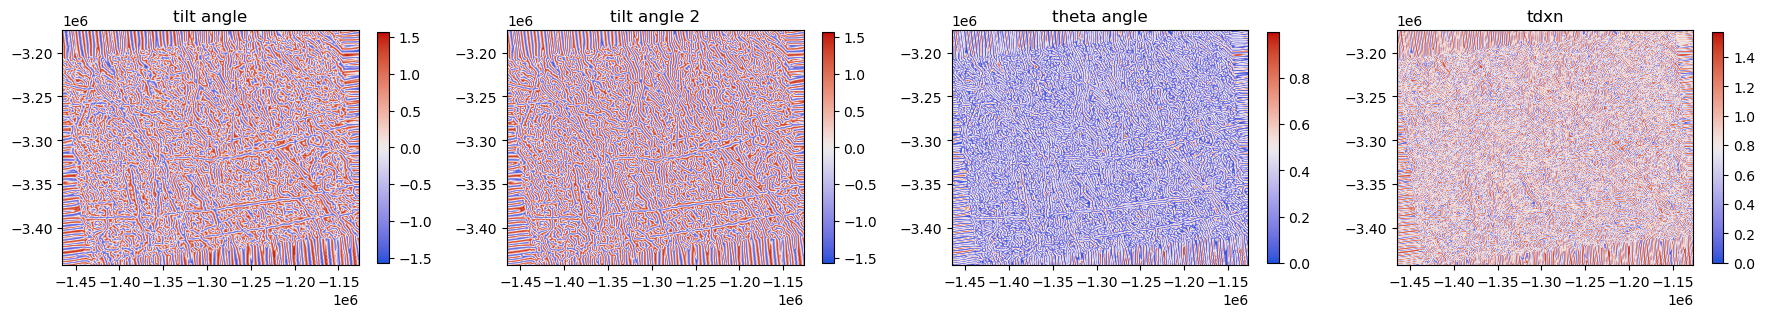

In [16]:

sigma=1
# ~ ~  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# th_div = thd(in_x[-1], in_y[:, 0], data1.ravel(), (nrow, ncol), sigma=sigma)
th_div = thd(in_x, in_y, data1.ravel(), (nrow, ncol), sigma=sigma)
th_div = th_div.reshape((nrow, ncol))

tilt = tilt_angle(in_x, in_y, data1.ravel(), (nrow, ncol), sigma=sigma)
tilt = tilt.reshape((nrow, ncol))
tilt2 = tilt_angle2(in_x, in_y, data1.ravel(), (nrow, ncol), sigma=sigma)
tilt2 = tilt2.reshape((nrow, ncol))


theta_ang =  theta(in_x, in_y, data1.ravel(), (nrow, ncol), sigma=sigma)
theta_ang = theta_ang.reshape((nrow, ncol))
theta_ang = np.max(theta_ang.ravel())-theta_ang
tdxn = thd2dz(in_x, in_y, data1.ravel(), (nrow, ncol), sigma=sigma)
tdxn = tdxn.reshape((nrow, ncol))
tdxn = np.nanmax(tdxn.ravel())-tdxn

# display
fig, ax = plt.subplots(1, 4, figsize=(22, 10))
ax = ax.ravel()
ax1= ax[0].imshow(tilt, extent=extent_og, cmap=cc.cm.coolwarm)
ax[0].set_title('tilt angle')
fig.colorbar(ax1, ax = ax[0], shrink=0.3)
ax0=ax[1].imshow(tilt2, extent=extent_og, cmap=cc.cm.coolwarm)
ax[1].set_title('tilt angle 2')
fig.colorbar(ax0, ax = ax[1], shrink=0.3)
ax1=ax[2].imshow(theta_ang, extent=extent_og, cmap=cc.cm.coolwarm)
ax[2].set_title('theta angle')
fig.colorbar(ax1, ax = ax[2], shrink=0.3)
ax2=ax[3].imshow(tdxn, extent=extent_og, cmap=cc.cm.coolwarm)
ax[3].set_title('tdxn')
fig.colorbar(ax2, ax = ax[3], shrink=0.3)


## 3b. phase congruency and symmetry

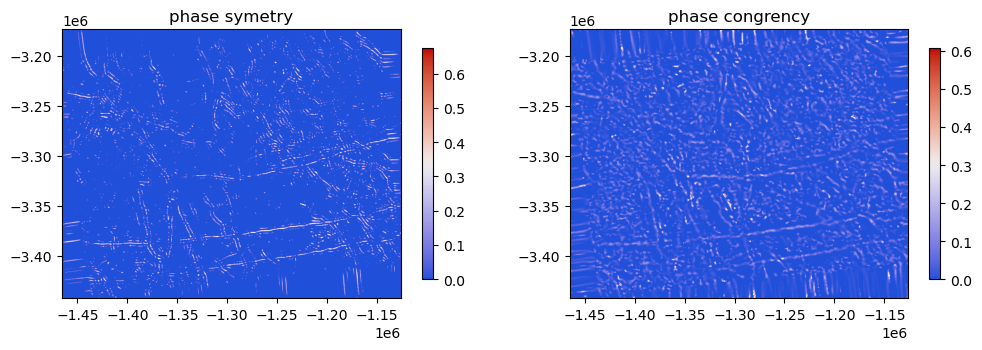

In [17]:

phaseSym, orient, symmetryEnergy, T = phasesym(data1, nscale=4, minWaveLength=3, mult=2.1, sigmaOnf=0.25, k=3, polarity=0, noiseMethod=-1)
PC, ori, ft, T2 = phasecongmono(data1, nscale=4, minWaveLength=2, mult=3.1, sigmaOnf=1.55, k=2, noiseMethod=-1)

# display
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax1 = ax[0].imshow(phaseSym,  extent=extent_og, cmap=cc.cm.coolwarm) 
ax[0].set_title('phase symetry')
fig.colorbar(ax1, ax=ax[0], shrink=0.5)
ax2 = ax[1].imshow(PC, extent=extent_og, cmap=cc.cm.coolwarm) 
ax[1].set_title('phase congrency')
fig.colorbar(ax2, ax=ax[1], shrink=0.5)

# 4. extract lineaments

In [18]:
type = 'ridges'

if type == 'ridges': # sato filter
    parm = {'black_ridges': False, 'filter_obj_size': 50, 'block_size': None}
elif type == 'canny': 
    parm = {'sigma': 3}
elif type =='max':  # max
    parm = {'threshold_type': 'global', 'global_threshold': None, 'local_block_size': 'auto'}
else:
    print("wrong type name!")
 
lineobj = LineamentDetection()
ln_tilt = lineobj.fit(tilt, affine=in_transform).transform(type=type, **parm)
ln_tilt2 = lineobj.fit(tilt2, affine=in_transform).transform(type=type, **parm)
tilt2_r = np.nanmax(tilt2.ravel())-tilt2
ln_tilt2_r = lineobj.fit(tilt2_r, affine=in_transform).transform(type=type, **parm)

ln_theta = lineobj.fit(theta_ang, affine=in_transform).transform(type=type, **parm)
ln_tdxn = lineobj.fit(tdxn, affine=in_transform).transform(type=type, **parm)
ln_phasecong = lineobj.fit(PC, affine=in_transform).transform(type=type, **parm)
ln_phasesym = lineobj.fit(phaseSym, affine=in_transform).transform(type=type, **parm)

# dilate the line pixels
nsqr = 3
s = sp.ndimage.generate_binary_structure(2,6)
ln_tilt = morphology.dilation(ln_tilt, footprint=morphology.square(nsqr))
ln_tilt2 = morphology.dilation(ln_tilt2, footprint=morphology.square(nsqr))
ln_tilt2_r = morphology.dilation(ln_tilt2_r, footprint=morphology.square(nsqr))
ln_theta = morphology.dilation(ln_theta, footprint=morphology.square(nsqr))
ln_tdxn = morphology.dilation(ln_tdxn, footprint=morphology.square(nsqr))
ln_phasecong = morphology.dilation(ln_phasecong, footprint=morphology.square(nsqr))
ln_phasesym = morphology.dilation(ln_phasesym, footprint=morphology.square(nsqr))

# mask output if the input data is not in regular shape
if False:
    ln_tilt = ln_tilt & og_mask
    ln_tilt2 = ln_tilt2 & og_mask
    ln_theta = ln_theta & og_mask
    ln_tdxn = ln_tdxn & og_mask
    ln_phasecong = ln_phasecong & og_mask
    ln_phasesym = ln_phasesym & og_mask

Text(0.5, 1.0, 'from tdxn')

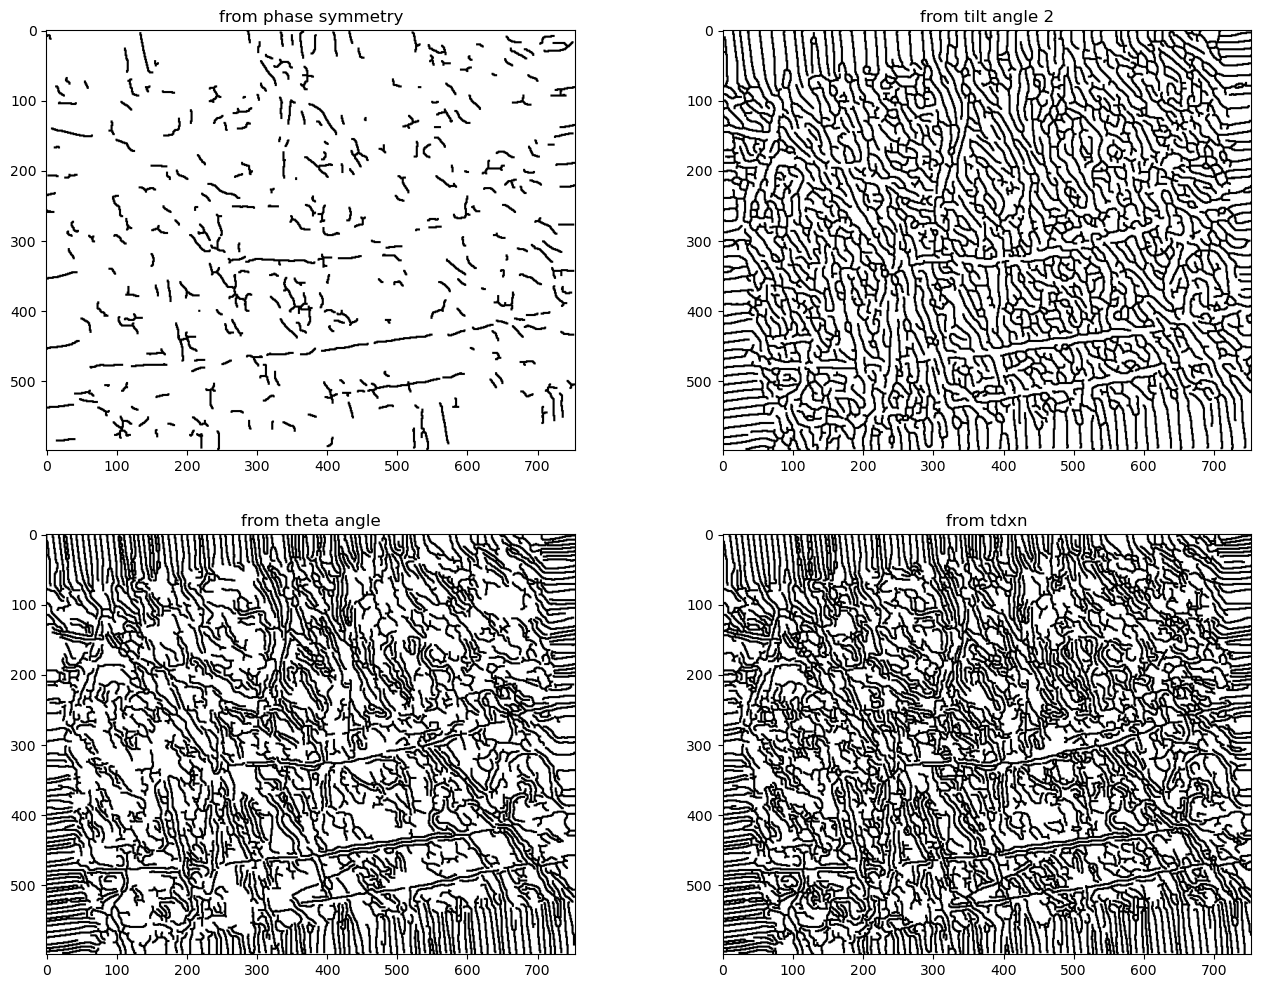

In [19]:
# display
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.ravel()
ax[0].imshow(ln_phasecong, cmap='gray_r')
ax[0].set_title('from phase symmetry')
ax[1].imshow(ln_tilt2, cmap='gray_r') # d2a for negative polarity
ax[1].set_title('from tilt angle 2')
ax[2].imshow(ln_theta, cmap='gray_r')
ax[2].set_title('from theta angle')
ax[3].imshow(ln_tdxn, cmap='gray_r')
ax[3].set_title('from tdxn')


### Blog: One map to compare different methods

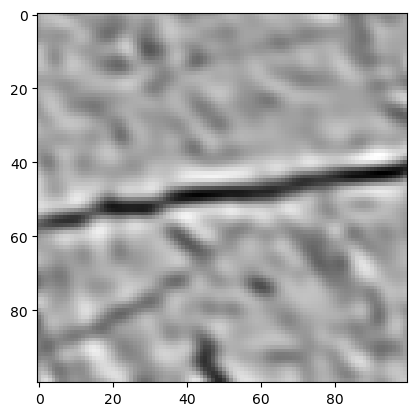

In [134]:
plt.imshow(data1[400:500, 400:500], cmap='gray')

In [135]:
parm_sato1 = {'black_ridges': False, 'filter_obj_size': 15, 'block_size': None}
parm_sato2 = {'black_ridges': True, 'filter_obj_size': 15, 'block_size': None}
parm_canny = {'sigma': 3}
parm_max = {'threshold_type': 'global', 'global_threshold': None, 'local_block_size': 'auto'}

# ln_data = np.zeros_like(data1)
ln_data = []
i = 0
for parm  in (parm_sato1, parm_sato2, parm_canny):
    i += 1
    lineobj = LineamentDetection()
    ln_temp = lineobj.fit(data1, affine=in_transform).transform(type=type, **parm)
    ln_temp = ln_temp*1
    # ln_temp[ln_temp==0] = np.nan
    ln_data.append(ln_temp[400:500, 400:500])
    # ln_data += i*ln_temp

ln_phasecong = lineobj.fit(PC, affine=in_transform).transform(type=type, **parm)
ln_data.append(ln_phasecong[400:500, 400:500])
ln_phasesym = lineobj.fit(phaseSym, affine=in_transform).transform(type=type, **parm)
ln_data.append(ln_phasesym[400:500, 400:500])


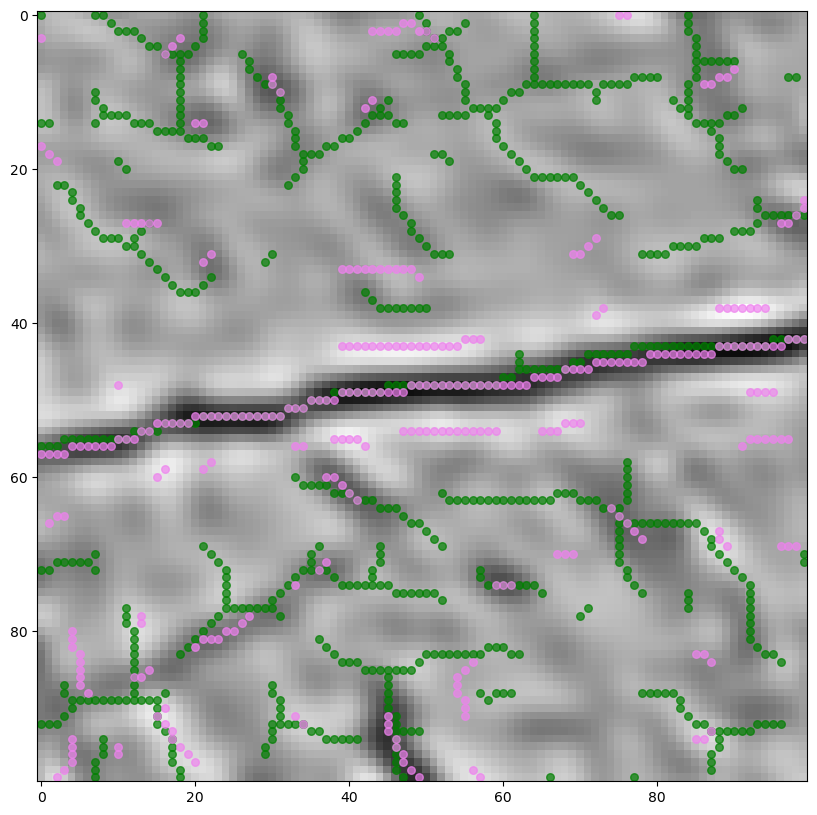

In [140]:

fig, ax=plt.subplots(figsize=(10, 10))
ax.imshow(data1[400:500, 400:500], cmap='gray')

# indices = np.argwhere(ln_data[2] == 1)
# ax.scatter(indices[:, 1], indices[:, 0], color='blue', s=30)

# indices = np.vstack((np.argwhere(ln_data[0] == 1), np.argwhere(ln_data[1] == 1)))
# ax.scatter(indices[:, 1], indices[:, 0], color='red', s=25, alpha=0.7)

indices = np.argwhere(ln_data[3] == 1)
ax.scatter(indices[:, 1], indices[:, 0], color='green', s=30, alpha=0.7)
indices = np.argwhere(ln_data[4] == 1)
ax.scatter(indices[:, 1], indices[:, 0], color='violet', s=30, alpha=0.7)

plt.show()


# 5. phase symmetry lineament output

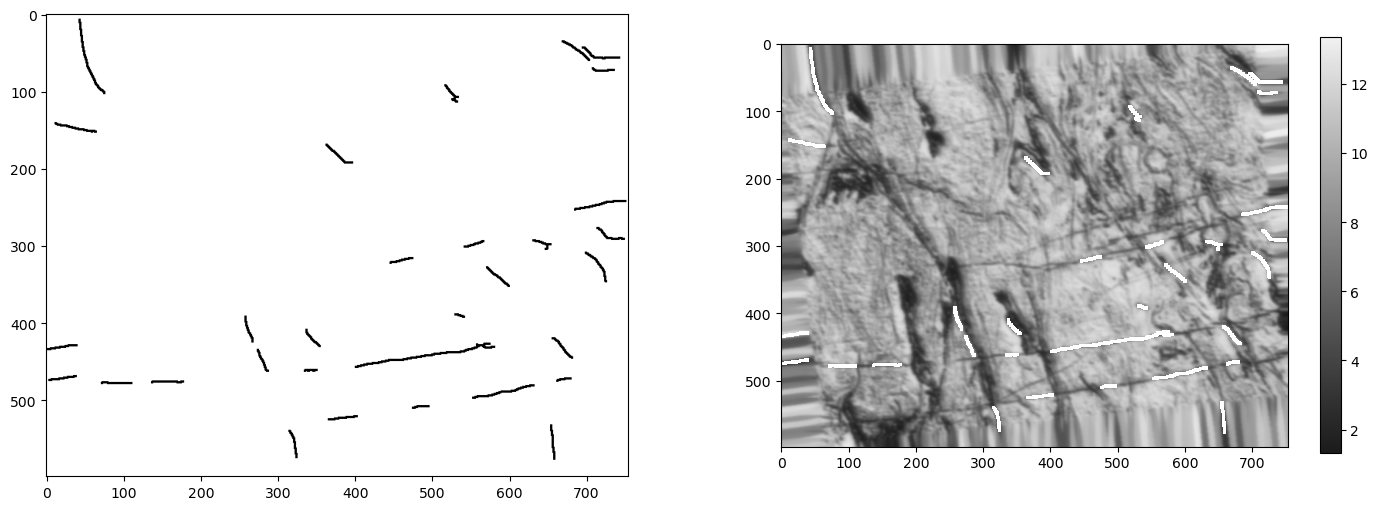

In [28]:
ln_phasesym_masked = np.ma.masked_array(data, mask=ln_phasesym)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].imshow(ln_phasesym>0, cmap='gray_r')
ax1 = ax[1].imshow(ln_phasesym_masked, cmap=cc.cm.dimgray)
fig.colorbar(ax1, ax = ax[1], shrink=0.9)

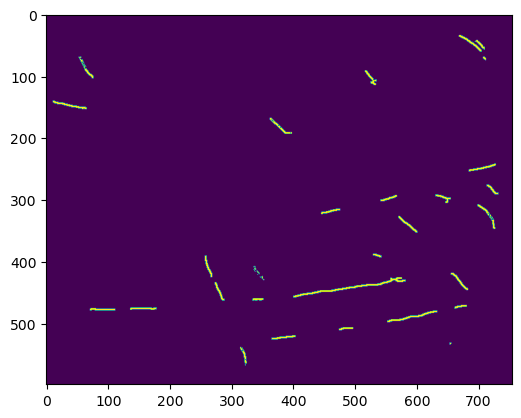

In [29]:
ln_phasesym2 = np.full(ln_phasesym.shape, False)
ln_phasesym2[mask] = ln_phasesym[mask]
plt.imshow(ln_phasesym2)

In [30]:
ln_phasesym2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [31]:
in_crs

CRS.from_epsg(7845)

<Axes: >

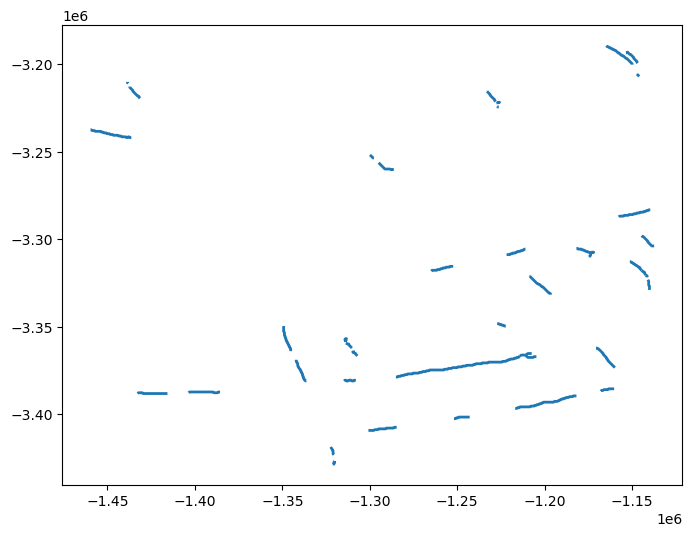

In [32]:
# %%time
phasesym_lines, phasesym_intxn_xy = binarr2lines(morphology.thin(ln_phasesym2), affine=in_transform)
phasesym_lines = merge_connected_lines(phasesym_lines, phasesym_intxn_xy, eps = 0.005)

# phasesym_gpd = gpd.GeoDataFrame({'geometry': phasesym_lines, 'length': [i.length*6373 for i in phasesym_lines]}, crs=in_crs)
phasesym_gpd = gpd.GeoDataFrame({'geometry': phasesym_lines, 'length': [i.length for i in phasesym_lines]}, crs=in_crs)
fig, ax = plt.subplots(1, figsize=(8, 8))
phasesym_gpd.plot(ax=ax, linewidth=2)

In [ ]:
phasesym_gpd.to_file(r"20240424.shp")

# 6. lineaments from colocation

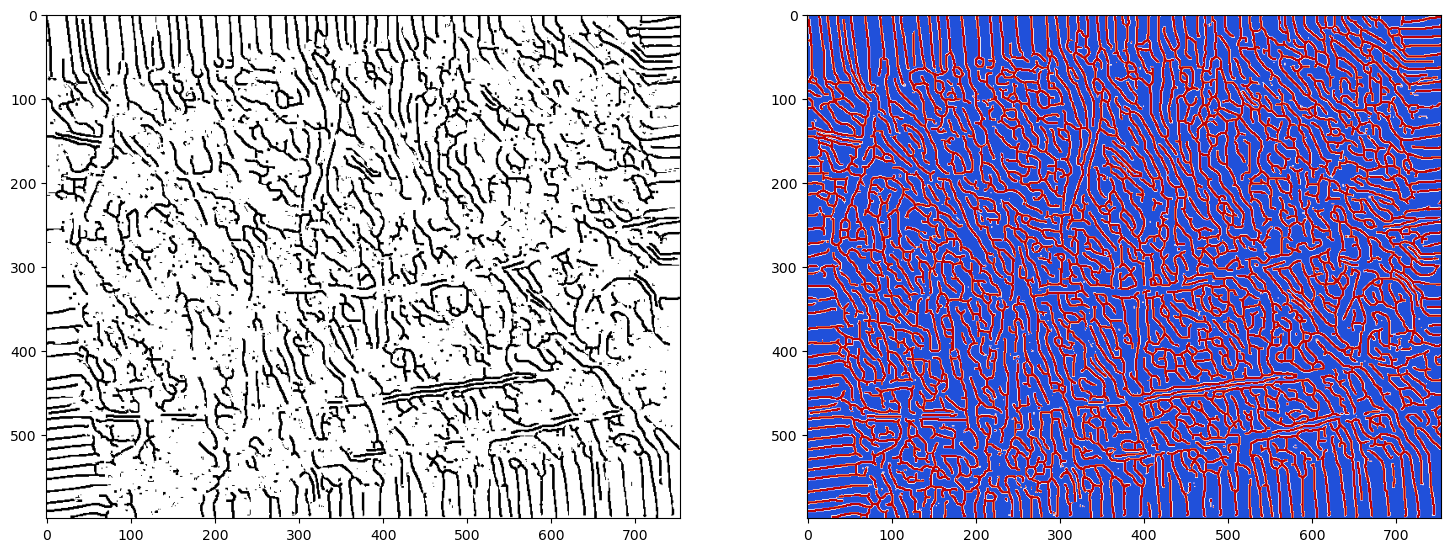

In [33]:
# colocation from products which include positive and negative polarities
# lineaments from: ln_tilt, ln_tilt2, ln_theta, ln_tdxn, ln_phasesym, ln_phasecong
coloc =  1*ln_tilt+ 1*ln_theta + 1*ln_phasesym               # pick products for colocation
ncoloc = 3                                                      # threshold for colocation
# use tilt to controle positive or negative lineaments
coloc_p = coloc+1*ln_tilt2 # pos
coloc_n = coloc+1*ln_tilt2_r # neg
coloc = coloc_p + coloc_n

# display
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax[0].imshow(coloc>ncoloc, cmap='gray_r')
ax1 = ax[1].imshow(coloc_p>1, cmap=cc.cm.coolwarm)
# fig.colorbar(ax1, ax = ax[1])

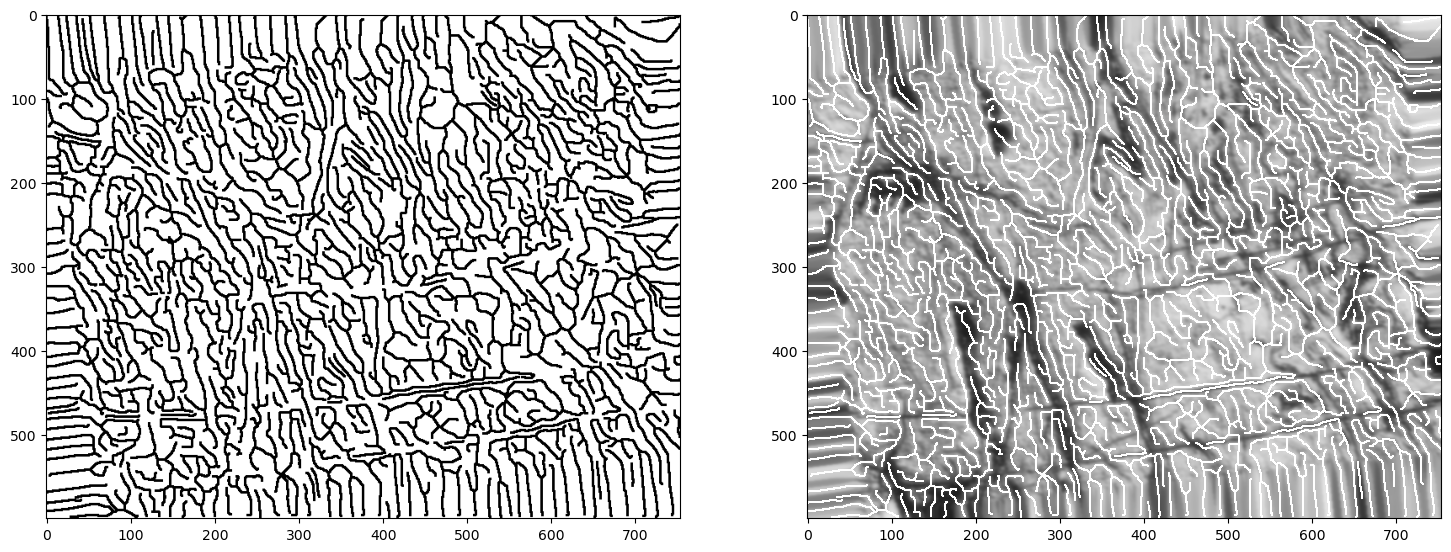

In [34]:

# coloc = morphology.area_closing(coloc>ncoloc, area_threshold=64)
coloc = morphology.area_closing(coloc_p>1, area_threshold=500)
coloc = morphology.skeletonize(coloc)
coloc = prune_branches(coloc, 10)
coloc = clear_short_binary_lines(coloc, 15)
coloc_2mask=coloc.copy()
coloc = morphology.dilation(coloc, footprint=s)


fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].imshow(coloc, cmap='gray_r')
ax[1].imshow(np.ma.masked_array(data, mask=coloc_2mask), cmap=cc.cm.dimgray)#'gray')

In [ ]:
coloc

In [ ]:
coloc2= np.full(coloc.shape, False)
coloc2[mask] = coloc[mask]
plt.imshow(coloc2)

In [ ]:
%%time
coloc_lines, coloc_intxn_xy = binarr2lines(morphology.thin(coloc2), affine=in_transform)
coloc_lines = merge_connected_lines(coloc_lines, coloc_intxn_xy, eps = 0.01)

# pot_lines2 = filter_line_by_curvature(pot_lines)
lines_gpd = gpd.GeoDataFrame({'geometry': coloc_lines, 'length': [i.length*6373 for i in coloc_lines]}, crs=in_crs)
fig, ax = plt.subplots(1, figsize=(12, 10))
lines_gpd.plot(ax=ax, linewidth=2)

In [ ]:
lines_gpd.to_file(r"C:\Users\bsun\Box\Greenland data for Jon\Sigguup_RMI_RTP_coloc_lines_tilt_theta_phsym.shp")

# 7. Multiscale colocation map
1. from the input of original data,
2. upward continued to various levels,
3. apply one method of lineament enhancement, phase symmetry is preferred,
4. lineament extraction for all levels of the data,
5. colocate the lineament extraction outputs.

In [ ]:

heights = [200, 500, 800, 1000, 1500, 2000, 2500, 3000]

data_in = data_og.copy()
# fill nan
if np.any(np.isnan(data_in)):
    mask = np.where(~np.isnan(data_in))
    interp = sp.interpolate.NearestNDInterpolator(np.transpose(mask), data_in[mask])
    data_in = interp(*np.indices(data_in.shape))
    
# filter parameter affects the outcomes, so need to experiment
data_in = filters.butterworth(data_in, 0.005, True)
# data_in = filters.difference_of_gaussians(data_in, low_sigma=1.5)#, high_sigma=3)
updata = []
for h in heights:
    dd = upcontinue(cols*ds, rows*ds, data_in, (nrow, ncol), h).reshape((nrow, ncol))
    dd = filters.difference_of_gaussians(dd, 1.5)
    updata.append(dd)

# display
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax = ax.ravel()
for i, h in enumerate(heights):
    ax[i].imshow(updata[i], cmap=cc.cm.coolwarm)
    ax[i].set_title(str(h)+'m')


In [ ]:
d.T

In [ ]:
trans_method='phasesym'
xian = []
for d in updata:
    if trans_method=='phasesym':
        this_xian, orient, symmetryEnergy, T = phasesym(d, nscale=4, norient=8, minWaveLength=3, mult=2.1, sigmaOnf=0.25, k=2, polarity=0, noiseMethod=-1)
    elif trans_method=='tilt':
        this_xian = tilt_angle(in_x[-1], in_y[:, 0], d.ravel(), (nrow, ncol), sigma=1).reshape((nrow, ncol))
    xian.append(this_xian)
    
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax = ax.ravel()
for i, h in enumerate(heights):
    ax[i].imshow(xian[i], cmap=cc.cm.coolwarm)
    ax[i].set_title(str(h)+'m')

In [ ]:

ln_coloc = []
type = 'ridges'

if type == 'ridges': # sato filter
    parm = {'black_ridges': False, 'filter_obj_size': 5, 'block_size': None}
elif type == 'canny': 
    parm = {'sigma': 3}
elif type =='max':  # max
    parm = {'threshold_type': 'global', 'global_threshold': None, 'local_block_size': 'auto'}
else:
    print("wrong type name!")
 

lineobj = LineamentDetection()
for this_xian, h in zip(xian, heights):
    # if h>8000: # apply a taper to reduce the edge effects
    #     this_xian *=filters.window(('tukey', 0.3), this_xian.shape)
    ln_coloc.append(lineobj.fit(this_xian, affine=in_transform).transform(type=type, **parm))
    
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax = ax.ravel()
for i, h in enumerate(heights):
    ax[i].imshow(ln_coloc[i], cmap=cc.cm.dimgray_r)
    ax[i].set_title(str(h)+'m')

In [ ]:

apply_wt = False
buffer=5
cl = 1*morphology.dilation(ln_coloc[0], morphology.square(nsqr)) * (heights[0]*0.001 if apply_wt else 1.)
end=7
for i, h in zip(ln_coloc[1:end], heights[1:end]):
    cl += morphology.dilation(i, morphology.square(buffer))*(h*0.001 if apply_wt else 1.)
    
# display
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax1=ax[0].imshow(cl, extent=extent_og, cmap=cc.cm.dimgray_r)
fig.colorbar(ax1,ax=ax[0], shrink=0.6)
ax2 = ax[1].imshow(data_og, extent=extent_og, cmap=cc.cm.coolwarm) 
fig.colorbar(ax2,ax=ax[1], shrink=0.6)